<a href="https://colab.research.google.com/github/HlibBorovko/KSVD/blob/main/%D0%91%D0%BE%D1%80%D0%BE%D0%B2%D0%BA%D0%BE_%D0%93%D0%BB%D1%96%D0%B1_%D0%9B%D0%B1_7_%D0%9A%D0%A1%D0%92%D0%94_4_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [10]:
# Завантаження та перетворення
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [11]:
# Поділ на train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# Додавання шуму
def add_noise(inputs, noise_factor=0.4):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clip(noisy, 0., 1.)

In [13]:
# Модель автокодувальника
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, output_padding=1, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, output_padding=1, padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Тренування
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        noisy_imgs = add_noise(imgs).to(device)
        imgs = imgs.to(device)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


In [17]:
# Валідація
model.eval()
val_loss = 0.0
with torch.no_grad():
      for imgs, _ in val_loader:
            noisy_imgs = add_noise(imgs).to(device)
            imgs = imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, imgs)
            val_loss += loss.item()
val_loss /= len(val_loader)
val_losses.append(val_loss)

print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 10/10 | Train Loss: 0.0098 | Val Loss: 0.0097


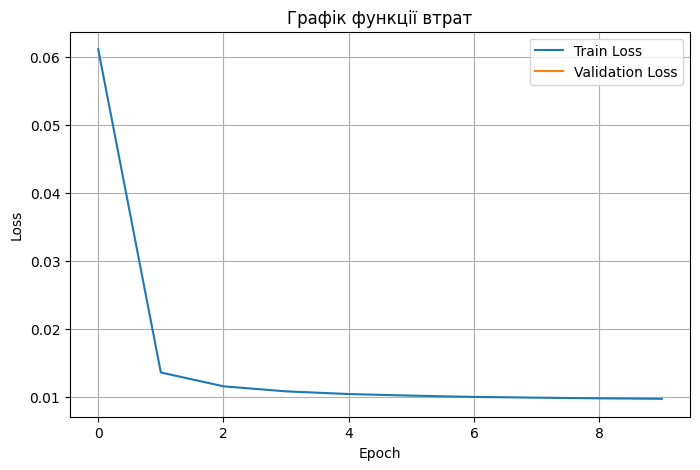

In [18]:
# Графік втрат
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Графік функції втрат")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Показ результатів
def show_images(original, noisy, reconstructed, n=6):
    plt.figure(figsize=(12,4))
    for i in range(n):
        # Оригінал
        plt.subplot(3, n, i + 1)
        plt.imshow(original[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel("Оригінал")

        # Шум
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel("З шумом")

        # Реконструкція
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(reconstructed[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel("Вихід")
    plt.tight_layout()
    plt.show()


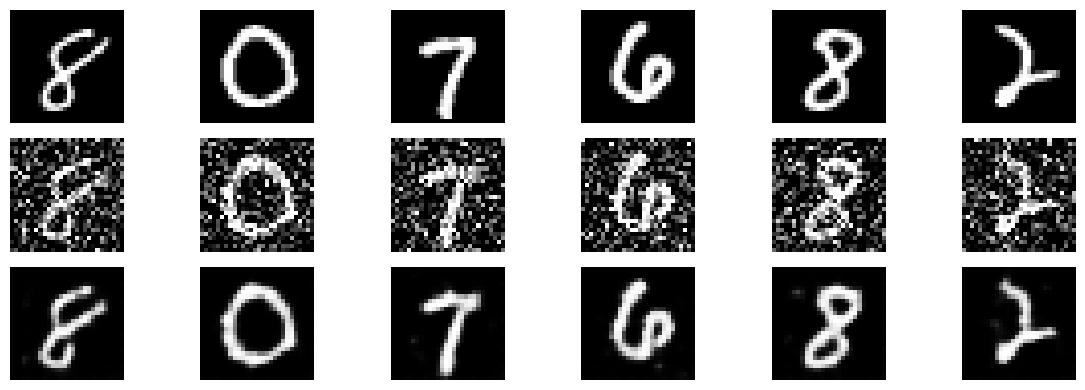

In [20]:
# Демонстрація результату
model.eval()
examples = next(iter(val_loader))[0][:6]
noisy_examples = add_noise(examples)
reconstructed = model(noisy_examples.to(device)).cpu().detach()

show_images(examples, noisy_examples, reconstructed)

**У ході лабораторної роботи було реалізовано автокодувальник на основі згорткової нейронної мережі для обробки зображень рукописних цифр із шумом. За допомогою PyTorch була побудована модель, що навчалась розпізнавати та відновлювати зашумлені зображення з датасету MNIST.**